In [110]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt

#### Word2Vec
import gensim
from gensim.models import Word2Vec

####
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torchutils as tu
from sklearn.model_selection import train_test_split
from collections import Counter

from torchmetrics.classification import BinaryAccuracy
from dataclasses import dataclass
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
from stop_words import get_stop_words

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
df = pd.read_json('/home/nikita/ds-phase-2/10-nlp/NLP-proj/data/healthcare_facilities_reviews.jsonl', lines=True)[['content', 'sentiment']]

In [112]:
def get_improved_russian_stopwords():
    """Улучшенный словарь стоп-слов, сохраняющий негативные контексты"""
    stop_words = set(get_stop_words('russian'))
    
    # УДАЛЯЕМ отрицательные слова из стоп-слов (очень важно!)
    negative_words_to_keep = {
        'не', 'нет', 'ни', 'никак', 'никогда', 'нисколько', 'ничуть',
        'отсутствует', 'плохо', 'ужасно', 'кошмар', 'отвратительно',
        'так себе', 'не очень', 'не понравилось', 'не нравится'
    }
    
    # Убираем отрицательные слова из стоп-слов
    stop_words = stop_words - negative_words_to_keep
    
    # Дополнительные стоп-слова для русского языка
    additional_stopwords = {
        'это', 'вот', 'как', 'так', 'и', 'в', 'над', 'к', 'до',
        'на', 'но', 'за', 'то', 'с', 'ли', 'а', 'во', 'от', 'со',
        'для', 'о', 'же', 'ну', 'вы', 'бы', 'что', 'кто', 'он', 'она'
    }
    
    return stop_words.union(additional_stopwords)

stop_words = get_improved_russian_stopwords()

In [113]:
import re
from stop_words import get_stop_words

# Загружаем русские стоп-слова
russian_stopwords = stop_words

def clean_text(text):
    """
    Очистка текста: нижний регистр, удаление пунктуации, цифр и стоп-слов
    """
    # 1. Приводим к нижнему регистру
    text = text.lower()
    
    # 2. Убираем знаки препинания (кроме дефиса)
    text = re.sub(r'[^\w\s-]', '', text)
    
    # 3. Убираем цифры
    text = re.sub(r'\d+', '', text)
    
    # 4. Разбиваем текст на слова
    words = text.split()
    
    # 5. УДАЛЯЕМ СТОП-СЛОВА (самое важное!)
    # Оставляем только слова, которых НЕТ в списке стоп-слов
    filtered_words = [word for word in words if word not in russian_stopwords]
    
    # 6. Собираем обратно в текст
    clean_text = ' '.join(filtered_words)
    
    return clean_text

df['content'] = df['content'].apply(clean_text)

In [114]:
X_train, X_val, y_train, y_val = train_test_split(df['content'], df['sentiment'])

In [115]:
tfidf = TfidfVectorizer(max_features=5000)
encoded_train = tfidf.fit_transform(X_train)
encoded_val = tfidf.transform(X_val)


In [116]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [117]:
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(encoded_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [118]:
model.score(encoded_val, y_val)

0.9371671388101983

LogReg F1-macro: 0.9351444391359346


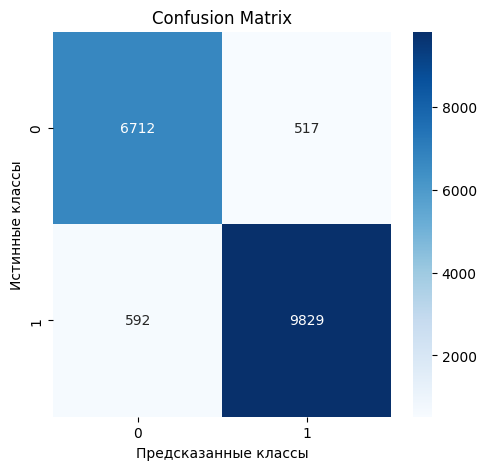

In [121]:
pred = model.predict(encoded_val)
from sklearn.metrics import confusion_matrix, f1_score
cm1 = confusion_matrix(y_val, pred)
print(f'LogReg F1-macro: {f1_score(y_val, pred, average='macro')}')

import seaborn as sns
plt.figure(figsize=(12, 5))

# Визуализация для первого классификатора
plt.subplot(1, 2, 1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы');